The Dataset is assumed to be placed in the root dir of google drive
The Drive is assumed to be allready mounted

In [1]:
#partialy based on:
#https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
#https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

In [2]:
!git clone https://github.com/uonat/SS2023_DI-Lab_Precitaste.git

Cloning into 'SS2023_DI-Lab_Precitaste'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 237 (delta 72), reused 189 (delta 39), pack-reused 0
Receiving objects: 100% (237/237), 23.00 MiB | 21.73 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [3]:
!mv SS2023_DI-Lab_Precitaste ./SS2023_DI_Lab_Precitaste

In [4]:
!unzip -q -n drive/MyDrive/retail-product-checkout-dataset.zip val2019/*

In [5]:
!unzip -q -n drive/MyDrive/retail-product-checkout-dataset.zip instances_val2019.json

In [6]:
using_colab = True

In [7]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    #!mkdir images
    #!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    #!wget -N https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    #!wget -N https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
    !wget -N https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-grezsh_z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-grezsh_z
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=67198148bf67c578e45347af928162bc243e865fffd4cef148656cee50dc1551
  Stored in directory: /tmp/pip-ephem-wheel-cache-j20w3yix/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segm

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

#sam_checkpoint = "sam_vit_h_4b8939.pth"
#model_type = "vit_h"
#sam_checkpoint = "sam_vit_l_0b3195.pth"
#model_type = "vit_l"
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"


device = "cuda" if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [11]:
def show_box(box, ax):
    x,y,w,h=box
    ax.add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=2))    


In [12]:
from SS2023_DI_Lab_Precitaste.dataset.RPCDataset import RPCDataset

val_dataset_path = "/content/"
val_dataset = RPCDataset(val_dataset_path, "val")

In [13]:
from random import randint

rand_idx = randint(0, val_dataset.get_num_imgs()-1)
print(rand_idx)

img_path = val_dataset.get_img_path_by_id(rand_idx)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

4877


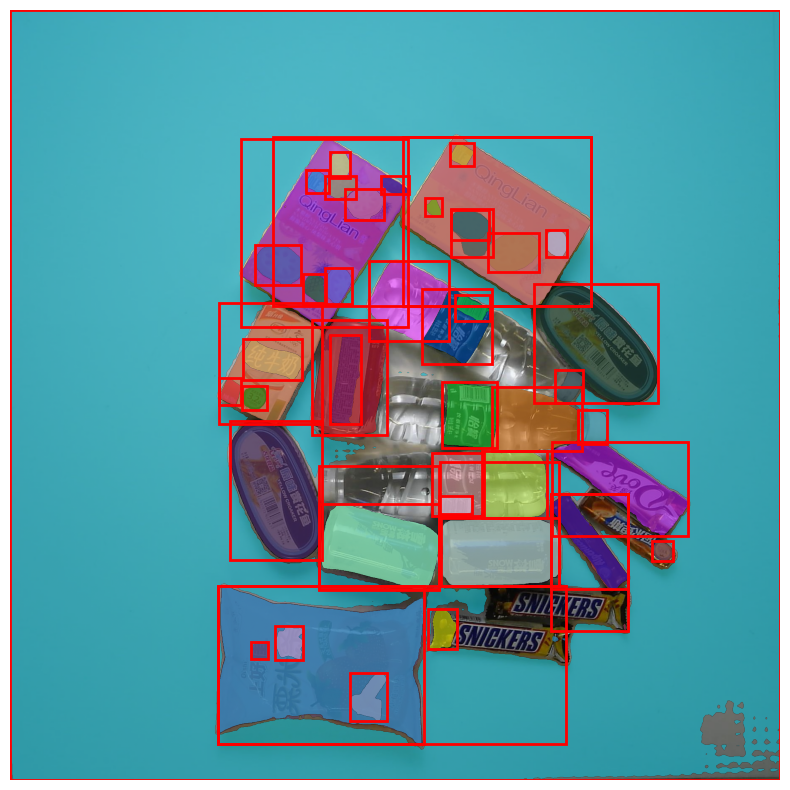

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(img)
for seg in masks:
  show_box(seg['bbox'], plt.gca())
  show_mask(seg['segmentation'], plt.gca(),True)
plt.axis('off')
plt.show()

In [15]:
plt.close()

In [16]:
len(masks)

50

In [17]:
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

In [18]:
masks[0]['bbox']

[0.0, 0.0, 1834.0, 1834.0]

In [19]:
for seg in masks:
  print(seg['predicted_iou'],seg['stability_score'])

1.002066969871521 0.9565173387527466
0.9863557815551758 0.9809345602989197
0.9853819608688354 0.9639049172401428
0.9844114184379578 0.9799066185951233
0.9819778800010681 0.9811753630638123
0.9811999797821045 0.9832640290260315
0.978449285030365 0.9763489961624146
0.974931538105011 0.9676871299743652
0.9736513495445251 0.9611771106719971
0.9723258018493652 0.9710614085197449
0.9706376194953918 0.974405825138092
0.9667907953262329 0.9754108786582947
0.9658260941505432 0.9696125388145447
0.9566510915756226 0.9545133113861084
0.9559363126754761 0.9622841477394104
0.9550551176071167 0.9756125807762146
0.9528408646583557 0.9664574861526489
0.9524500370025635 0.9814356565475464
0.9454765319824219 0.9661597013473511
0.945060133934021 0.9728124737739563
0.9444962739944458 0.966325044631958
0.9434623718261719 0.9605184197425842
0.9421738982200623 0.9703379273414612
0.9374692440032959 0.9819494485855103
0.9347904324531555 0.9817554354667664
0.9301294088363647 0.9530665278434753
0.9291927814483643

# Evaluate on Dataset
## Generate predictiones file

In [20]:
import os
pred_txt_path = "/content/drive/MyDrive/rpc-val-preds"
os.makedirs(pred_txt_path, exist_ok=True)

In [21]:
from tqdm.notebook import tqdm


for i in tqdm(range(val_dataset.get_num_imgs())):
  img_path = val_dataset.get_img_path_by_id(i)


  pred_img_name = val_dataset.img_info[i]['file_name']
  pred_txt_name = "".join(pred_img_name.split('.')[:-1]) + ".txt"
  pred_txt = os.path.join(pred_txt_path, pred_txt_name)

  if not os.path.exists(pred_txt):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with torch.no_grad():
      masks = mask_generator.generate(img)



    with open(pred_txt, "w") as txtfile:
      for seg in masks:    
        conf = seg['predicted_iou']
        x,y,w,h=seg['bbox']
        

        txtfile.write("object {} {} {} {} {}\n".format(conf, x, y, w, h))

  0%|          | 0/6000 [00:00<?, ?it/s]